# Upgrade and Install Packages If Needed

In [ ]:
#!pip install wordcloud
#!pip install threadpoolctl --upgrade

# Load Packages

In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from wordcloud import WordCloud
from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deesw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Training Data and Drop Unessesary Columns

In [ ]:
#import training data - csv
#paste in file location starting with 'C:\\ and ending in .csv
data = pd.read_csv('C:\\ .csv')

#import training data - excel
#paste in file location starting with r'C:\\ and ending in .csv'
#data = pd.read_excel(r'C: .xlsx')

In [54]:
#drop a range of columns
data = data.drop(data.loc[:, 'Law':'Technology/IT'].columns, axis=1)
#drop rows based on having a specifis value in a column
data.drop(data.index[data['Company Field'] == 'Blank/Individual'], inplace = True)
data.drop(data.index[data['chatgpt description']=='no description, blank company or individual'], inplace = True)
data.drop(data.index[data['chatgpt description']== 'no description, blank company or individual CPA'], inplace = True)
data.drop(data.index[data['chatgpt description']== 'no description, blank company or law individual'], inplace = True)
#display information on variables now in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3453 entries, 0 to 4446
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 3453 non-null   object
 1   email                3452 non-null   object
 2   state                3452 non-null   object
 3   company              3453 non-null   object
 4   Company Field        3453 non-null   object
 5   industry detail      3453 non-null   object
 6   chatgpt description  3453 non-null   object
 7   law description      3453 non-null   object
 8   law description2     3451 non-null   object
 9   law short            3453 non-null   object
dtypes: object(10)
memory usage: 296.7+ KB


In [55]:
#Larger Datasets can take a while to load. Save the imported data set to another name to run instead of importing again if a mistake is made later on. 
lister_fulltrain = data
#view the first 5 rows
lister_fulltrain.head()

,Name,email,state,company,Company Field,industry detail,chatgpt description,law description,law description2,law short
0,leslie heffernen,l.heffernen@pitcairn.com,Pennsylvania,Pitcairn Trust Co,Banking,Trust Company,Pitcairn Trust Co is a leading provider of wea...,"Unfortunately, we cannot answer this question ...",not a law firm,not a law firm
1,Pamela Landy,pamela@mylifecycleplanners.com,Michigan,Lifecycle Financial Planners,Financial Services,Other,Lifecycle Financial Planners is a financial ad...,Lifecycle Financial Planners is not a law offi...,not a law firm,not a law firm
3,Paul Kent,paul@americantaxprofessionals.com,California,American Tax Professionals,Financial Services,Tax Services & Accounting,American Tax Professionals is a tax preparatio...,American Tax Professionals is not a law office...,not a law firm,not a law firm
4,Greg DuPont,Greg@DandBlaw.com,Ohio,DuPont and Blumenstiel,Law,"Corporate Law, Intellectual Property Law, Envi...",DuPont is a multinational company operating in...,DuPont and Blumenstiel does not appear to be a...,"Corporate Law, Intellectual Property Law, Envi...","Corporate Law, Intellectual Property Law, Envi..."
5,ed weidenfeld,edward.weidenfeld@gmail.com,District Of Columbia,Weidenfeld Law,Law,"corporate law, tax law, real estate law, intel...",Weidenfeld Law is a law firm specializing in c...,Weidenfeld Law is a law firm that specializes ...,"Corporate Law, Tax Law, Intellectual Property Law","corporate law, tax law, real estate law, intel..."


# Preprocess Training Text Data and Create Document Inputs for Model 

In [56]:
# Remove punctuation
lister_fulltrain['chatgpt description2'] = ""
lister_fulltrain['chatgpt description2'] = lister_fulltrain['chatgpt description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
lister_fulltrain['chatgpt description processed'] = \
lister_fulltrain['chatgpt description processed'] = lister_fulltrain['chatgpt description2'].map(lambda x: x.lower())
# Print out the first rows to see if looks right
lister_fulltrain['chatgpt description processed'].head()

0    pitcairn trust co is a leading provider of wea...
1    lifecycle financial planners is a financial ad...
3    american tax professionals is a tax preparatio...
4    dupont is a multinational company operating in...
5    weidenfeld law is a law firm specializing in c...
Name: chatgpt description processed, dtype: object

In [57]:
#process short law description text
# Remove punctuation
lister_fulltrain['law short2'] = ""
lister_fulltrain['law short2'] = lister_fulltrain['law short'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#lister['chatgpt description'] = \
lister_fulltrain['law short processed'] = lister_fulltrain['law short2'].map(lambda x: x.lower())
# Print out the first rows
lister_fulltrain['law short processed'].head()

0                                       not a law firm
1                                       not a law firm
3                                       not a law firm
4    corporate law intellectual property law enviro...
5    corporate law tax law real estate law intellec...
Name: law short processed, dtype: object

In [58]:
#factorize company field - new columnn with the Manual industries coded into numbers representing each
lister_fulltrain['Industry Number'] = pd.factorize(lister_fulltrain['Company Field'])[0]
#view first 5 rows
#lister_fulltrain.head()

In [59]:
#replace black or NA values in the description column
fill = "no description blank company or individual"

lister_fulltrain['chatgpt description processed'].fillna(fill, inplace = True)
lister_fulltrain['chatgpt description'].fillna(fill, inplace = True)
lister_fulltrain = lister_fulltrain.dropna(subset=['chatgpt description processed'])

In [60]:
#save description column on its own and view
text = lister_fulltrain['chatgpt description processed']
text.head

<bound method NDFrame.head of 0       pitcairn trust co is a leading provider of wea...
1       lifecycle financial planners is a financial ad...
3       american tax professionals is a tax preparatio...
4       dupont is a multinational company operating in...
5       weidenfeld law is a law firm specializing in c...
                              ...                        
4442    weston hurd is a law firm that specializes in ...
4443    robert g stewart pc is a law firm specializing...
4444    thomas j wolf jr pc is a law firm specializing...
4445    bailey cavalieri llc is a law firm specializin...
4446    richard c williams jr pa is a law firm special...
Name: chatgpt description processed, Length: 3453, dtype: object>

In [61]:
#convert the text column variable into a list and remove None values
train_documents = text.values.tolist()
train_documents = list(filter(lambda x: x is not None, train_documents))
#train_documents 

In [62]:
#create the documents for the clustering as the train_documents list
documents = train_documents

# Kmeans Clustering Algorithm with Text Inputs

In [63]:
#initialize the text vectorizer with englush stop words: TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
#set inputs X as the vectorized documents
X = vectorizer.fit_transform(documents)

Selecting the Amount of Clusters, k, with the Elbow Method
* An optimal selection is usually when the line bends and the point become closer together
* There is no set correct amount, different selections can be made and run to see what the best fit will be
* The amount of k will vary on the task and data used. 
* This Analysis: k=10 was chosen. optimal k lies beteew about 5-10 and input from the manual anlaysis was also taken into consideration of the amount of groups manually seen for the amount of k to choose. This way we coul daccount for other possible subindusties amoung the data. 

In [64]:
#run clusters on many k selections with the X inputs
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

C:\Users\deesw\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


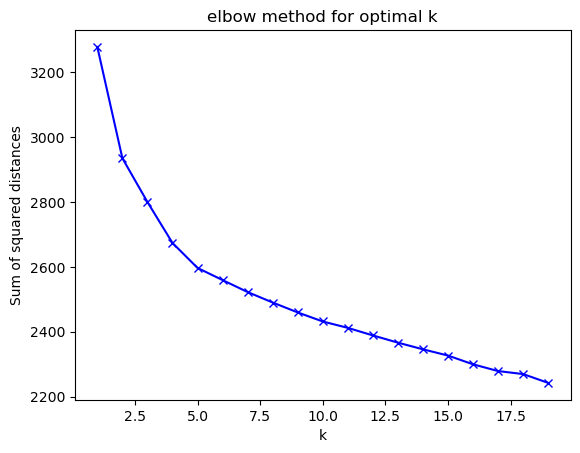

In [14]:
#output the elbow method plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title("elbow method for optimal k")
plt.show()
#optimal k lies beteew about 5-10

Running the Clustering Model

In [83]:
#fit model to the training data: text documents X
k = 10 # edit k here to explore results of different k selections
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [91]:
#model fits all documents into a cluster
#save the cluster assignments as a new column in the dataset
lister_fulltrain['cluster'] = model.labels_

In [92]:
#view the first 5 rows, cluster numbers should be on the end now
lister_fulltrain.head()

,Name,email,state,company,Company Field,industry detail,chatgpt description,law description,law description2,law short,chatgpt description2,chatgpt description processed,law short2,law short processed,Industry Number,cluster
0,leslie heffernen,l.heffernen@pitcairn.com,Pennsylvania,Pitcairn Trust Co,Banking,Trust Company,Pitcairn Trust Co is a leading provider of wea...,"Unfortunately, we cannot answer this question ...",not a law firm,not a law firm,Pitcairn Trust Co is a leading provider of wea...,pitcairn trust co is a leading provider of wea...,not a law firm,not a law firm,0,4
1,Pamela Landy,pamela@mylifecycleplanners.com,Michigan,Lifecycle Financial Planners,Financial Services,Other,Lifecycle Financial Planners is a financial ad...,Lifecycle Financial Planners is not a law offi...,not a law firm,not a law firm,Lifecycle Financial Planners is a financial ad...,lifecycle financial planners is a financial ad...,not a law firm,not a law firm,1,7
3,Paul Kent,paul@americantaxprofessionals.com,California,American Tax Professionals,Financial Services,Tax Services & Accounting,American Tax Professionals is a tax preparatio...,American Tax Professionals is not a law office...,not a law firm,not a law firm,American Tax Professionals is a tax preparatio...,american tax professionals is a tax preparatio...,not a law firm,not a law firm,1,8
4,Greg DuPont,Greg@DandBlaw.com,Ohio,DuPont and Blumenstiel,Law,"Corporate Law, Intellectual Property Law, Envi...",DuPont is a multinational company operating in...,DuPont and Blumenstiel does not appear to be a...,"Corporate Law, Intellectual Property Law, Envi...","Corporate Law, Intellectual Property Law, Envi...",DuPont is a multinational company operating in...,dupont is a multinational company operating in...,Corporate Law Intellectual Property Law Enviro...,corporate law intellectual property law enviro...,2,7
5,ed weidenfeld,edward.weidenfeld@gmail.com,District Of Columbia,Weidenfeld Law,Law,"corporate law, tax law, real estate law, intel...",Weidenfeld Law is a law firm specializing in c...,Weidenfeld Law is a law firm that specializes ...,"Corporate Law, Tax Law, Intellectual Property Law","corporate law, tax law, real estate law, intel...",Weidenfeld Law is a law firm specializing in c...,weidenfeld law is a law firm specializing in c...,corporate law tax law real estate law intellec...,corporate law tax law real estate law intellec...,2,0


# Visualizations of the Documents (Text Descriptions)

In [18]:
#creat a list of stop words to not include in the visualizations
#these are fillers or words that are very common and displayed to much over the importatnt words we care about
stop = ['and', 'other','to','area','areas','possible','specialize', "office", 'specializes', 'is', 'not', 'a', 'that', 'or', 'in', 'of', 'including', 'answer','this']

Word Cloud for All Company Descriptions

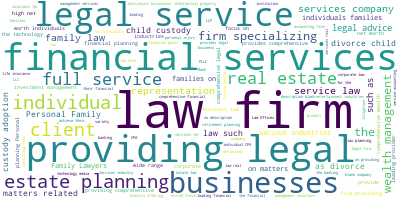

In [138]:
# Join the different processed titles together.
long_string = ','.join(list(lister_fulltrain['chatgpt description'].values))
# Create a WordCloud object - all inputs can be edited for a different visual result
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue', 
                      stopwords=stop)
# Generate a word cloud FOR ALL DESCRIPTIONS
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Word Cloud of All Law Descritptions

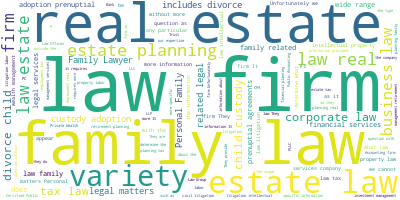

In [145]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(lister_fulltrain['law description'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop)
# Generate a word cloud FOR ALL LAW DESCRIPTIONS
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

All Law Descriptions Word Cloud Redone Excludig Filler/Unessesary Words ie Stop Words

In [19]:
#craete another list of stops words to remove from the crowded law wordcloud
stop2 = ['and', 'other','to','area','areas','possible','specialize', "firm", "office", 'law', 'specializes', 'is', 'not', 'a', 'that', 'or', 'in', 'of', 'including', 'answer','this']

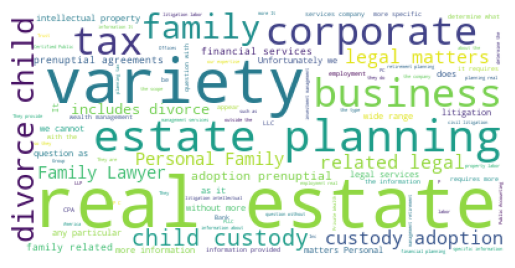

In [154]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',stopwords= stop2).generate(' '.join(lister_fulltrain['law description']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Short Law Description Word Cloud

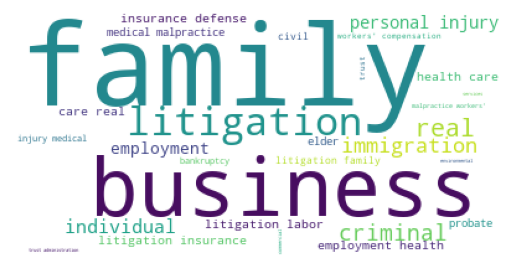

In [173]:
stop3 = ['and', 'corporate','planning','tax','other',"intellectual","property",'estate','to','area','areas','possible','specialize', "firm", "office", 'law', 'specializes', 'is', 'not', 'a', 'that', 'or', 'in', 'of', 'including', 'answer','this']
#SHORT LAW DESCRIPTIONS law word cloud redone excludig filler/unessesary words ie stop words
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',stopwords= stop3).generate(' '.join(lister_fulltrain['law short processed']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Visualizing the Clusters

Top Terms from the Descriptions within Each Cluster 

In [93]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 law
 legal
 firm
 specializing
 estate
 areas
 business
 providing
 litigation
 clients
Cluster 1:
 financial
 management
 wealth
 investment
 services
 planning
 company
 individuals
 families
 specializes
Cluster 2:
 law
 entertainment
 media
 technology
 focus
 industries
 service
 corporate
 specializing
 firm
Cluster 3:
 insurance
 life
 mutual
 financial
 northwestern
 services
 businesses
 company
 annuities
 individuals
Cluster 4:
 trust
 management
 wealth
 services
 company
 financial
 institutions
 families
 provides
 individuals
Cluster 5:
 real
 industries
 law
 clients
 healthcare
 estate
 service
 services
 firm
 legal
Cluster 6:
 family
 lawyers
 adoption
 child
 divorce
 custody
 related
 matters
 specialize
 representation
Cluster 7:
 industry
 services
 financial
 banking
 leading
 solutions
 range
 bank
 products
 company
Cluster 8:
 accounting
 tax
 consulting
 professional
 various
 businesses
 industries
 services
 firm
 cpa
Clu

Function to print out word clouds for each cluster but will capture more filler words than the top terms list above. 
Can initialize a list of stop words like earlier to output visuals without

In [88]:
def word_cloud(text, wc_title):
    # Create stopword list
    stopword_list = set(STOPWORDS) 

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopword_list, 
                           min_font_size = 14).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (8, 6)) 
    
    # Set title for word cloud
    plt.title(wc_title)
    
    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # save word cloud
    #plt.savefig(wc_file_name,bbox_inches='tight')

    # show plot
    plt.show()

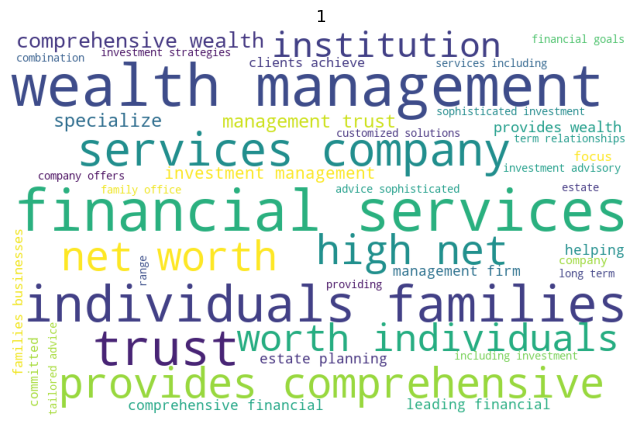

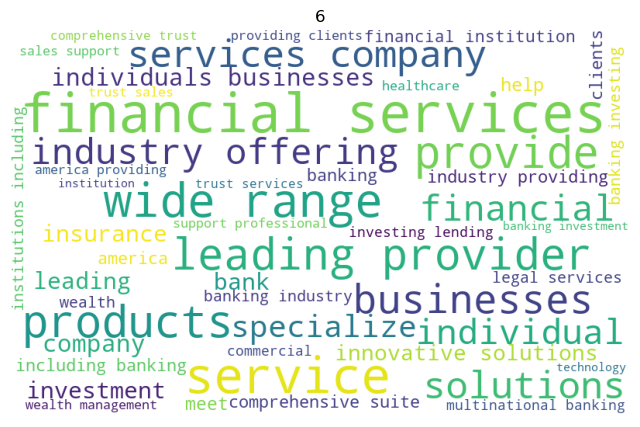

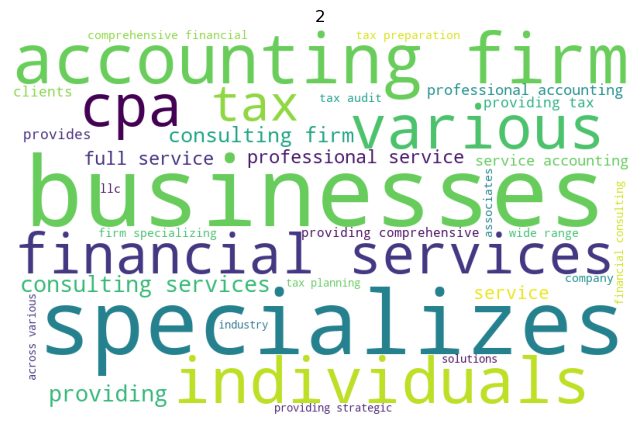

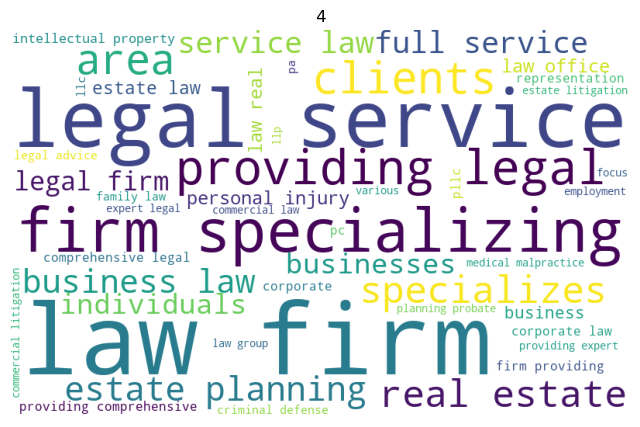

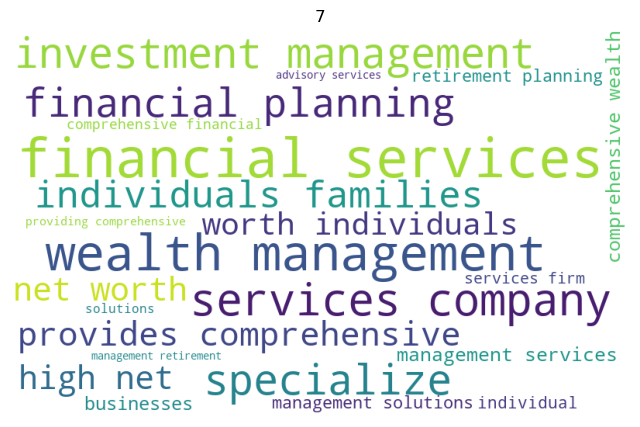

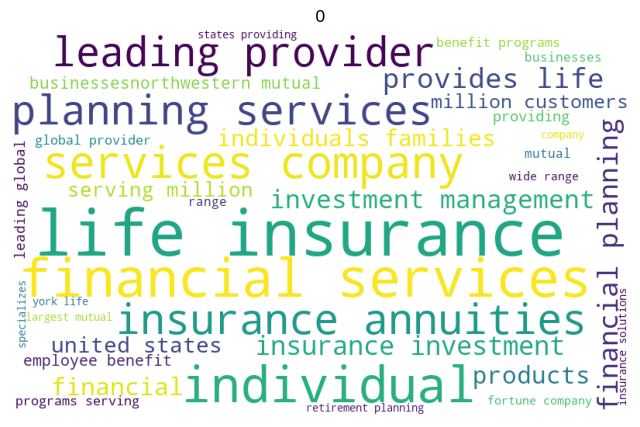

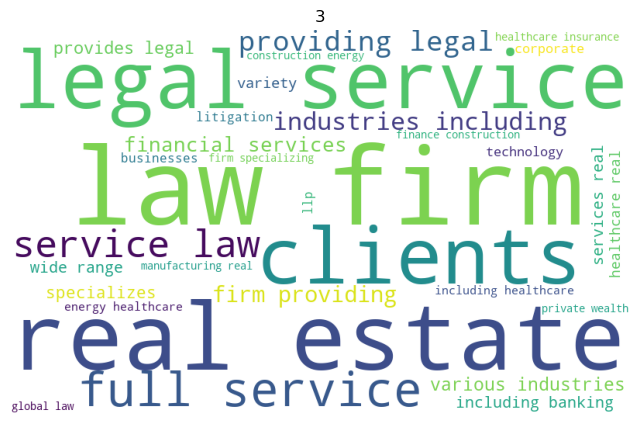

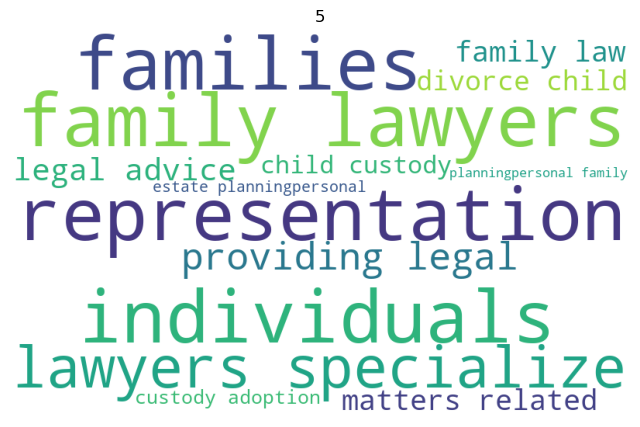

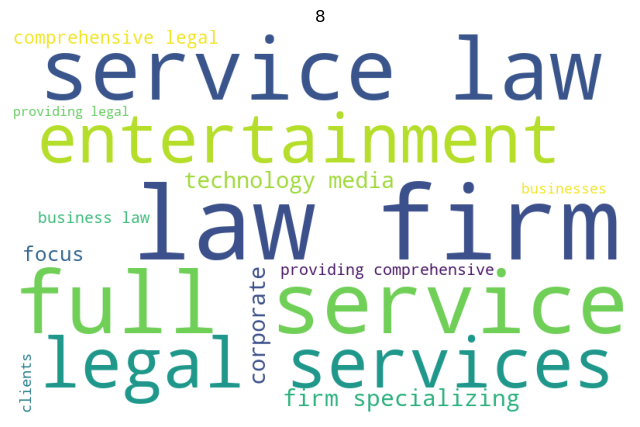

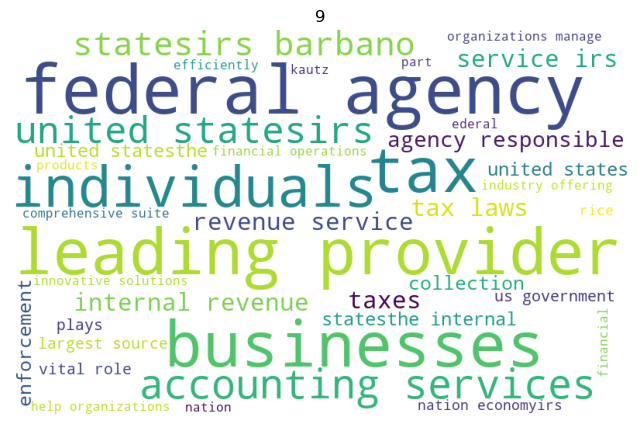

In [94]:
#output of function to group text description in each cluster label
lister=pd.DataFrame({"text":lister_fulltrain['chatgpt description processed'],"labels":lister_fulltrain['cluster']})


for i in lister.labels.unique():
    new_lister=lister[lister.labels==i]
    text="".join(new_lister.text.tolist())
    word_cloud(text, lister.labels.unique()[i]))

# Name the Clusters and Map Names to the Cluster Numbers

In [26]:
#total unique clusters
lister.labels.unique()

array([0, 3, 9, 4, 5, 6, 7, 8, 2, 1])

In [101]:
#map cluster names by naming the clusters based on key words and word clouds
current_labels = lister.labels.unique()
desired_labels = ('Law','Financial Services','Other', 'Insurance', 'Banking - Trust',
    'Law', ' Law - Family', 'Banking', 'Financial Services - Tax & Accounting' ,'Government')
# create a dictionary for your corresponding values
map_dict = dict(zip(current_labels, desired_labels))
map_dict= {0: 'Law', 1: 'Financial Services - Wealth & Invest', 2: 'Other', 3: 'Insurance', 4: 'Banking - Trust',
    5: 'Law', 6:' Law - Family', 7:'Banking & Finance', 8:'Financial Services - Tax & Accounting' ,9:'Government'}

# map the desired values back to the dataframe
# this will replace the original values
#lister_fulltrain['cluster'] = lister_fulltrain['cluster'].map(map_dict)

#map to a new column if you want to preserve the old values
lister_fulltrain['cluster names'] = lister_fulltrain['cluster'].map(map_dict)

In [ ]:
# manual industry fields assigned for reference
#Banking
#Financial Services
#Blank/Individual
#Law
#Insurance
#Business & Estate Planning
#Government 
#Nonprofit
#Manufacturing/Industrial
#Real Estate
#Technology/IT
#Healthcare
#Education
#Insurance 


In [102]:
lister_fulltrain.head()

,Name,email,state,company,Company Field,industry detail,chatgpt description,law description,law description2,law short,chatgpt description2,chatgpt description processed,law short2,law short processed,Industry Number,cluster,cluster names
0,leslie heffernen,l.heffernen@pitcairn.com,Pennsylvania,Pitcairn Trust Co,Banking,Trust Company,Pitcairn Trust Co is a leading provider of wea...,"Unfortunately, we cannot answer this question ...",not a law firm,not a law firm,Pitcairn Trust Co is a leading provider of wea...,pitcairn trust co is a leading provider of wea...,not a law firm,not a law firm,0,4,Banking - Trust
1,Pamela Landy,pamela@mylifecycleplanners.com,Michigan,Lifecycle Financial Planners,Financial Services,Other,Lifecycle Financial Planners is a financial ad...,Lifecycle Financial Planners is not a law offi...,not a law firm,not a law firm,Lifecycle Financial Planners is a financial ad...,lifecycle financial planners is a financial ad...,not a law firm,not a law firm,1,7,Banking & Finance
3,Paul Kent,paul@americantaxprofessionals.com,California,American Tax Professionals,Financial Services,Tax Services & Accounting,American Tax Professionals is a tax preparatio...,American Tax Professionals is not a law office...,not a law firm,not a law firm,American Tax Professionals is a tax preparatio...,american tax professionals is a tax preparatio...,not a law firm,not a law firm,1,8,Financial Services - Tax & Accounting
4,Greg DuPont,Greg@DandBlaw.com,Ohio,DuPont and Blumenstiel,Law,"Corporate Law, Intellectual Property Law, Envi...",DuPont is a multinational company operating in...,DuPont and Blumenstiel does not appear to be a...,"Corporate Law, Intellectual Property Law, Envi...","Corporate Law, Intellectual Property Law, Envi...",DuPont is a multinational company operating in...,dupont is a multinational company operating in...,Corporate Law Intellectual Property Law Enviro...,corporate law intellectual property law enviro...,2,7,Banking & Finance
5,ed weidenfeld,edward.weidenfeld@gmail.com,District Of Columbia,Weidenfeld Law,Law,"corporate law, tax law, real estate law, intel...",Weidenfeld Law is a law firm specializing in c...,Weidenfeld Law is a law firm that specializes ...,"Corporate Law, Tax Law, Intellectual Property Law","corporate law, tax law, real estate law, intel...",Weidenfeld Law is a law firm specializing in c...,weidenfeld law is a law firm specializing in c...,corporate law tax law real estate law intellec...,corporate law tax law real estate law intellec...,2,0,Law


# Clustering On New Data

import new data you would like to fit into the clusters from the model and preprocess text fields

In [133]:
data2 = pd.read_excel(r'C:\\ .xlsx')
#drop range of columns not needed
data2 = data2.drop(data2.loc[:, 'Law':'Technology/IT'].columns, axis=1)
#drop rows based on a specific value in one column
data2.drop(data2.index[data2['Company Field'] == 'Blank/Individual'], inplace = True)
#print out infomrmation on all columns now
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   3404 non-null   object 
 1   email                  3401 non-null   object 
 2   company                3404 non-null   object 
 3   Company Field          3404 non-null   object 
 4   industry detail        0 non-null      float64
 5   chatgpt description    3404 non-null   object 
 6   law description        3397 non-null   object 
 7   law description short  3397 non-null   object 
dtypes: float64(1), object(7)
memory usage: 212.9+ KB


In [134]:
#save data as a new set
lister_pred = data2
# change variable types if needed
#lister_pred["chatgpt description"] = lister_pred["chatgpt description"].astype(str)
#lister_pred["company"] = lister_pred["company"].astype(str)
#lister_pred['law description']=lister_pred['law description'].astype(str)
#lister_pred['law description short']=lister_pred['law description short'].astype(str)
print(lister_pred.dtypes) #need to display as objects below

#preprocess the description text
# Remove punctuation
lister_pred['chatgpt description2'] = ""
lister_pred['chatgpt description2'] = lister_pred['chatgpt description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#lister['chatgpt description'] = \
lister_pred['chatgpt description processed'] = lister_pred['chatgpt description2'].map(lambda x: x.lower())
# Print out the first rows
lister_pred['chatgpt description processed'].head()


Name                      object
email                     object
company                   object
Company Field             object
industry detail          float64
chatgpt description       object
law description           object
law description short     object
dtype: object


0    psd is a technology software company that spec...
1    millman and associates is a consulting firm sp...
2    fogarty mueller harris pllc is a law firm spec...
3    don gary pllc is a law firm that specializes i...
4    blue williams llc is a law firm specializing i...
Name: chatgpt description processed, dtype: object

In [135]:
# Prediction short law description text
# Remove punctuation
lister_pred['law short2'] = ""
lister_pred['law short2'] = lister_pred['law description short'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
#lister['chatgpt description'] = \
lister_pred['law short processed'] = lister_pred['law short2'].map(lambda x: x.lower())
# Print out the first rows
lister_pred['law short processed'].head()

0    corporate law tax law intellectual property law
1    corporate law tax law intellectual property law
2              corporate law tax law estate planning
3    corporate law tax law intellectual property law
4    corporate law tax law intellectual property law
Name: law short processed, dtype: object

In [136]:
#make y prediction column
lister_pred['Industry Number'] = ""
lister_pred.head()

,Name,email,company,Company Field,industry detail,chatgpt description,law description,law description short,chatgpt description2,chatgpt description processed,law short2,law short processed,Industry Number
0,Manni Julka,maneesh_julka@yahoo.com,PSD,Predict,NaN,PSD is a technology software company that spec...,"Unfortunately, we cannot answer this question ...","Corporate Law, Tax Law, Intellectual Property Law",PSD is a technology software company that spec...,psd is a technology software company that spec...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,
1,Gerald Millman,gmillman001@aol.com,Millman and Associates,Predict,NaN,Millman and Associates is a consulting firm sp...,Millman and Associates is a law firm that spec...,"Corporate Law, Tax Law, Intellectual Property Law",Millman and Associates is a consulting firm sp...,millman and associates is a consulting firm sp...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,
2,Micah Fogarty,micah@fmhlegal.com,"Fogarty Mueller Harris, PLLC",Predict,NaN,"Fogarty Mueller Harris, PLLC is a law firm spe...","Fogarty Mueller Harris, PLLC is a law firm tha...","Corporate Law, Tax Law, Estate Planning",Fogarty Mueller Harris PLLC is a law firm spec...,fogarty mueller harris pllc is a law firm spec...,Corporate Law Tax Law Estate Planning,corporate law tax law estate planning,
3,DONALD GARY,don@dgarypllc.com,DON GARY PLLC,Predict,NaN,DON GARY PLLC is a law firm that specializes i...,It is not possible to determine what law DON G...,"Corporate Law, Tax Law, Intellectual Property Law",DON GARY PLLC is a law firm that specializes i...,don gary pllc is a law firm that specializes i...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,
4,Greg LaCour,glacour@bluewilliams.com,BLUE WILLIAMS LLC,Predict,NaN,BLUE WILLIAMS LLC is a law firm specializing i...,It is not possible to determine what law Blue ...,"Corporate Law, Tax Law, Intellectual Property Law",BLUE WILLIAMS LLC is a law firm specializing i...,blue williams llc is a law firm specializing i...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,


Create the Documents and Model Inputs

In [137]:
#save description as thier own variable, convert to a list, remove None values
text2 = lister_pred['chatgpt description processed']
text2.head
test_documents = text2.values.tolist()
test_documents = list(filter(lambda x: x is not None, test_documents))
#view the documents
#test_documents

In [139]:
#save the text as another set of documents
documents2 = test_documents

In [140]:
#vectorize the X input from the prediction data documents
#do not fit the vectorizer again, only need vectorizer.transform()
X2 = vectorizer.transform(documents2)

Predict Clusters on New Data Documents and Map Cluster Names to the Labels

In [141]:
#pred_labels are the clusters it assigns/predicts for the new data based on the training model already fit above
pred_labels = model.predict(X2) # test is your data to predict the cluster

In [142]:
#create column with the cluster labels for each row
lister_pred['cluster'] = pred_labels
#lister_pred.head()

In [144]:
#create column for cluster names to match the names mapped to the clusters earlier
lister_pred['cluster names'] = lister_pred['cluster'].map(map_dict)

In [145]:
#view the clusters
lister_pred.head()

,Name,email,company,Company Field,industry detail,chatgpt description,law description,law description short,chatgpt description2,chatgpt description processed,law short2,law short processed,Industry Number,cluster,cluster names
0,Manni Julka,maneesh_julka@yahoo.com,PSD,Predict,NaN,PSD is a technology software company that spec...,"Unfortunately, we cannot answer this question ...","Corporate Law, Tax Law, Intellectual Property Law",PSD is a technology software company that spec...,psd is a technology software company that spec...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,,7,Banking & Finance
1,Gerald Millman,gmillman001@aol.com,Millman and Associates,Predict,NaN,Millman and Associates is a consulting firm sp...,Millman and Associates is a law firm that spec...,"Corporate Law, Tax Law, Intellectual Property Law",Millman and Associates is a consulting firm sp...,millman and associates is a consulting firm sp...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,,8,Financial Services - Tax & Accounting
2,Micah Fogarty,micah@fmhlegal.com,"Fogarty Mueller Harris, PLLC",Predict,NaN,"Fogarty Mueller Harris, PLLC is a law firm spe...","Fogarty Mueller Harris, PLLC is a law firm tha...","Corporate Law, Tax Law, Estate Planning",Fogarty Mueller Harris PLLC is a law firm spec...,fogarty mueller harris pllc is a law firm spec...,Corporate Law Tax Law Estate Planning,corporate law tax law estate planning,,0,Law
3,DONALD GARY,don@dgarypllc.com,DON GARY PLLC,Predict,NaN,DON GARY PLLC is a law firm that specializes i...,It is not possible to determine what law DON G...,"Corporate Law, Tax Law, Intellectual Property Law",DON GARY PLLC is a law firm that specializes i...,don gary pllc is a law firm that specializes i...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,,0,Law
4,Greg LaCour,glacour@bluewilliams.com,BLUE WILLIAMS LLC,Predict,NaN,BLUE WILLIAMS LLC is a law firm specializing i...,It is not possible to determine what law Blue ...,"Corporate Law, Tax Law, Intellectual Property Law",BLUE WILLIAMS LLC is a law firm specializing i...,blue williams llc is a law firm specializing i...,Corporate Law Tax Law Intellectual Property Law,corporate law tax law intellectual property law,,0,Law


# Export the Data Sets to Further Explore the Clusters

In [146]:
lister_fulltrain.to_csv(r'C:\\ .txt', index = None, sep = ',', mode = 'w')
lister_pred.to_csv(r'C:\\  .txt', index = None, sep = ',', mode = 'w')